<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/03_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# @title **Librerias**
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random
import os
from mpl_toolkits.mplot3d import Axes3D

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

# Librerias de modelos
from sklearn.svm import SVR

# Deep learning
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Nosupervisado
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# **Carga del dataset y configuraciones**

In [2]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [3]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [4]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

# **Reducción de dimensionalidad**

In [27]:
#@title Partición y preparación del dataset

# Copia del DataFrame
df_r = df_encoded.copy()

# Variables predictoras (todas menos Exam_Score)
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo
y = df_r['Exam_Score']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train - 20% test
    random_state=42
)

# Escalador
scaler = StandardScaler()

# Ajuste del escalador con X_train y X_test (sin fit)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo colocamos como dataframe para mayor comodidad
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Todos los datos escalados para t-SNE
X_scaled = np.vstack([X_train_scaled, X_test_scaled])

y_full = pd.concat([y_train, y_test], axis=0).values

## **PCA**


 Varianza acumulada: 0.11489683569481018 



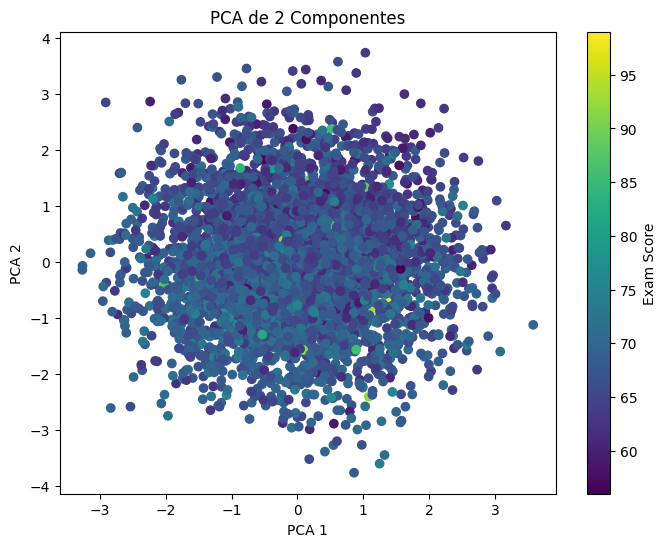

In [15]:
# @title Redución de la dimensionalidad de los datos **con solo dos componentes**

# PCA con solo 2 componentes
pca_2 = PCA(n_components=2)
X_train_pca2 = pca_2.fit_transform(X_train_scaled)

# Varianza explicada
varianza_2 = pca_2.explained_variance_ratio_
varianza_acumulada_2 = varianza_2.sum()
print(f"\n Varianza acumulada: {varianza_acumulada_2} \n")

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA de 2 Componentes")
plt.colorbar(label='Exam Score')
plt.show()

<h4>La varianza acumulada que se entrega muestra que se toma muy poca información de los datos y la gráfica es un demostrativo del gran ruido de los datos con dos componentes

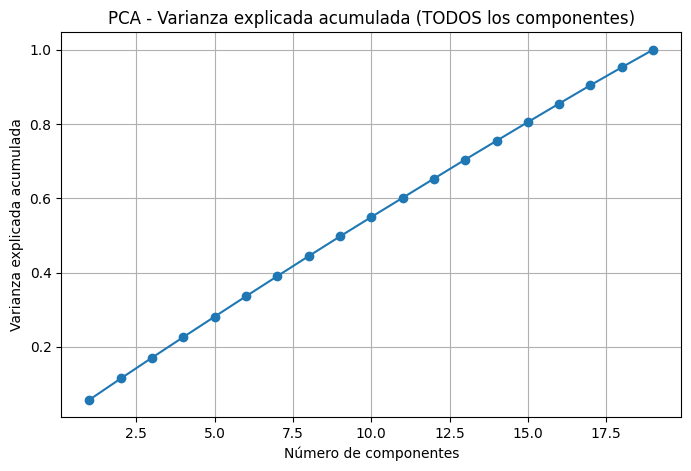

[0.05776323 0.11489684 0.17100217 0.22648032 0.28151864 0.33632818
 0.39045692 0.44427964 0.49735114 0.5495587  0.60123741 0.65286399
 0.70425772 0.75480878 0.80519306 0.85499739 0.90444399 0.9526517
 1.        ]

 Número mínimo de componentes para llegar al 95%: 18 

 Número mínimo de componentes para llegar al 99%: 19 


In [22]:
# @title PCA usando **todos los componentes**

pca_full = PCA()    # Todas los componentes
pca_full.fit(X_train_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_

# Varianza acumulada
cum_var = np.cumsum(explained_var)

# Gráfico de varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('PCA - Varianza explicada acumulada (TODOS los componentes)')
plt.grid(True)
plt.show()

# Varianza acumulada
print(cum_var[:])

# Número mínimo de componentes para llegar al 90% de varianza
n_comp_90 = np.argmax(cum_var >= 0.95) + 1

# Número mínimo de componentes para llegar al 95% de varianza
n_comp_95 = np.argmax(cum_var >= 0.99) + 1

print(f"\n Número mínimo de componentes para llegar al 95%: {n_comp_90} ")
print(f"\n Número mínimo de componentes para llegar al 99%: {n_comp_95} ")

Para obtener un gran margen (99%) se usa 19 componentes (es decir todos) y aprovechar todos los datos

In [23]:
# PCA con 19 componentes
pca_final = PCA(n_components=19) # podria ser simplemente pca_final = PCA()

# Ajustamos y transformamos TRAIN
X_train_pca = pca_final.fit_transform(X_train_scaled)

# Transformamos TEST
X_test_pca = pca_final.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((5101, 19), (1276, 19))

In [24]:
# @title Función de regresion
def flujo_regresion(modelo, param_grid, score, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring= score,
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring= score
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  absolte_error = mean_absolute_error(y_test, y_pred)
  mean_squared = mean_squared_error(y_test, y_pred)

  return grid, scores_folds, absolte_error, mean_squared, y_pred

In [25]:
# @title Entrenamiento **CON PCA** con SVR
# Modelo base
svr = SVR()

# Grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Métrica
score = make_scorer(mean_absolute_error, greater_is_better=False)

# Llamado del flujo usando datos PCA
grid_pca, scores_folds_pca, absolte_error_pca, mean_squared_pca, y_pred_pca = flujo_regresion(
    svr,
    param_grid,
    score,
    X_train_pca,
    X_test_pca,
    y_train,
    y_test
)

print("Mejores hiperparámetros (PCA):", grid_pca.best_params_)
print("Mejor evaluación promedio (PCA):", -grid_pca.best_score_)

print("\n \n Evaluación final con PCA:")
print("MAE:", round(absolte_error_pca, 4))
print("MSE:", round(mean_squared_pca, 4))

Mejores hiperparámetros (PCA): {'gamma': 0.01, 'kernel': 'sigmoid'}
Mejor evaluación promedio (PCA): 0.4447968911079661

 
 Evaluación final con PCA:
MAE: 0.4298
MSE: 4.126


In [26]:
# @title Entrenamiento **SIN PCA** con SVR

# Modelo base
svr = SVR()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, y_pred = flujo_regresion(svr, param_grid, score, X_train, X_test, y_train, y_test)

# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

# Evaluacion final del mejor modelo
print("\n\nEvaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Mejores hiperparámetros: {'gamma': 0.001, 'kernel': 'rbf'}
Mejor evaluación promedio: 0.6500471053963317


Evaluación final:
MAE: 0.5832
MSE: 4.32


### Comparación de rendimiento del modelo SVR con y sin PCA

| Modelo                     | MAE    | MSE    |
|----------------------------|--------|--------|
| SVR sin reducción (original) | 0.5832 | 4.3200 |
| SVR con PCA (19 componentes) | 0.4298 | 4.1260 |


<h2><b>Análisis referente al PCA</b></h2>

En el caso del rendimiento estudiantil, se entrenó un modelo SVR tanto con las características originales como con las características transformadas mediante PCA. Al utilizar PCA con 19 componentes principales, el modelo obtuvo un MAE de 0.4298 y un MSE de 4.126, mientras que con las características originales el MAE fue de 0.5832 y el MSE de 4.32. Es decir, la reducción de dimensionalidad en forma de PCA mejoró el rendimiento del modelo, reduciendo el error medio y el error cuadrático medio. Aunque en este caso la “reducción” no es muy fuerte (se usan todas las componentes), la transformación a componentes ortogonales parece ayudar al SVR a ajustar mejor la relación entre las variables explicativas y la nota de examen, posiblemente al eliminar correlaciones y ruido entre las características originales.

## **t-SNE:**

In [28]:
# Comprobación de dimensiones del X escalada y el y completo
X_scaled.shape, y_full.shape

((6377, 19), (6377,))

In [31]:
# @title Aplicación de t-SNE a dos componentes

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)
X_tsne.shape

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(6377, 2)

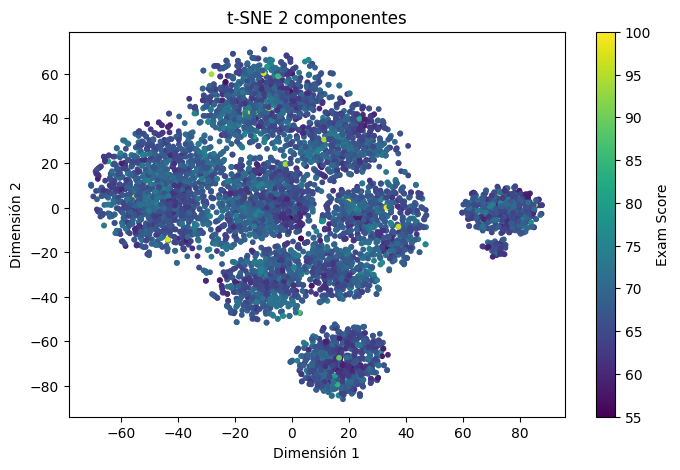

In [33]:
# @title Visualización de las dos componentes
plt.figure(figsize=(8,5))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y_full,
    cmap='viridis',
    s=10
)

plt.colorbar(label="Exam Score")
plt.title("t-SNE 2 componentes")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

In [34]:
# @title **Train/Test pero en el espacio t-SNE**
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X_tsne,
    y_full,
    test_size=0.2,
    random_state=42
)

X_train_tsne.shape, X_test_tsne.shape

((5101, 2), (1276, 2))

In [35]:
# @title Entrenamiento **CON t-SNE** con SVR

svr = SVR()

param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

score = make_scorer(mean_absolute_error, greater_is_better=False)

grid_tsne, scores_folds_tsne, absolte_error_tsne, mean_squared_tsne, y_pred_tsne = flujo_regresion(
    svr,
    param_grid,
    score,
    X_train_tsne,
    X_test_tsne,
    y_train_tsne,
    y_test_tsne
)

print("Mejores hiperparámetros (t-SNE):", grid_tsne.best_params_)
print("Mejor evaluación promedio (t-SNE):", -grid_tsne.best_score_)

print("Evaluación final (t-SNE):")
print("MAE:", round(absolte_error_tsne, 4))
print("MSE:", round(mean_squared_tsne, 4))

Mejores hiperparámetros (t-SNE): {'gamma': 0.1, 'kernel': 'rbf'}
Mejor evaluación promedio (t-SNE): 2.322187488370398
Evaluación final (t-SNE):
MAE: 2.1927
MSE: 8.2685


### Comparación de rendimiento del modelo SVR

| Representación de los datos     | MAE    | MSE    |
|---------------------------------|--------|--------|
| Sin reducción (características originales) | 0.5832 | 4.3200 |
| PCA (19 componentes principales)          | 0.4298 | 4.1260 |
| t-SNE (2 dimensiones)                     | 2.1927 | 8.2685 |


El modelo con t-SNE muestra un menor rendimiento a comparación del entrenamiento sin reducción de dimensión. El análisis se hará en ANÁLISIS GENERAL

## **Análisis general**



En el caso de PCA, se realizaron dos ejercicios: una reducción inicial a 2 componentes para visualización, donde solo se explicó el 11% de la varianza y se observó una fuerte pérdida de información y una reducción final a 19 componentes, manteniendo casi el 100% de la varianza del dataset. Al entrenar el modelo SVR sobre estas 19 componentes, se obtuvo un MAE de 0.4298 y un MSE de 4.126, mejorando el rendimiento obtenido con las características originales (MAE 0.5832, MSE 4.32).

Por otro lado, t-SNE se aplicó exclusivamente para generar una representación visual del dataset en 2 dimensiones, ya que esta técnica está diseñada para mantener relaciones locales y formar clusters visuales, no para preservar la estructura global del espacio ni la varianza. Aunque la visualización resultante mostró agrupamientos interesantes, el uso de t-SNE como transformador previo al modelo supervisado produjo resultados muy inferiores a los modelos entrenados con los datos originales o con PCA. Esto ocurre porque t-SNE está optimizado para visualización y no genera un espacio linealmente consistente o apto para modelado.

Comparando las tres representaciones (datos originales, PCA y t-SNE), se observó que la mejor estrategia para este problema de regresión fue el uso de PCA con 19 componentes, que permitió mejorar las métricas respecto al modelo basado en los datos originales, aunque la reducción de dimensionalidad fue mínima. La proyección t-SNE evidenció ser una herramienta útil para visualización, pero inadecuada para alimentar modelos supervisados, ya que desmejoró el rendimiento del SVR. En general,  la reducción de dimensionalidad puede mejorar un modelo siempre que preserve estructura relevante para la tarea (como PCA en este caso).

# **Aprendizaje no supervisado**

In [36]:
# @title Preparación del dataset

df_r = df_encoded.copy()

# Variables predictoras
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo (solo para análisis al final, clustering no usa y)
y = df_r['Exam_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# En formato DataFrame para comodidad
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,0.505278,0.344803,-1.562297,1.290854,-0.023928,-0.143302,-1.305379,-1.212085,-1.059809,-0.327989,1.068816,0.026518,-0.903890,-0.751306,-1.216700,0.286586,0.662215,-0.342065,0.853886
1,-0.163081,-1.387019,-1.562297,-0.140510,0.657282,-1.115616,-1.305379,0.409708,0.285414,-0.327989,-1.575545,0.998406,0.377307,0.740312,-1.216700,0.286586,0.662215,-0.342065,-1.171116
2,0.672367,1.557079,-0.123215,-0.140510,-0.023928,1.106816,0.132093,0.409708,0.285414,-0.327989,-0.253364,0.998406,1.658505,-0.751306,0.821896,0.286586,0.662215,-0.342065,0.853886
3,1.507815,0.777759,-1.562297,-0.140510,0.657282,1.592974,0.132093,-0.401188,0.285414,-0.327989,-1.575545,0.998406,-0.903890,0.740312,0.821896,0.286586,0.662215,-0.342065,0.853886
4,-0.163081,1.037532,-0.123215,-0.140510,-0.705139,-0.698910,0.132093,1.220605,0.285414,1.335960,-0.253364,0.998406,0.377307,-0.751306,0.821896,0.286586,0.662215,-0.342065,-1.171116


## **K-MEANS**



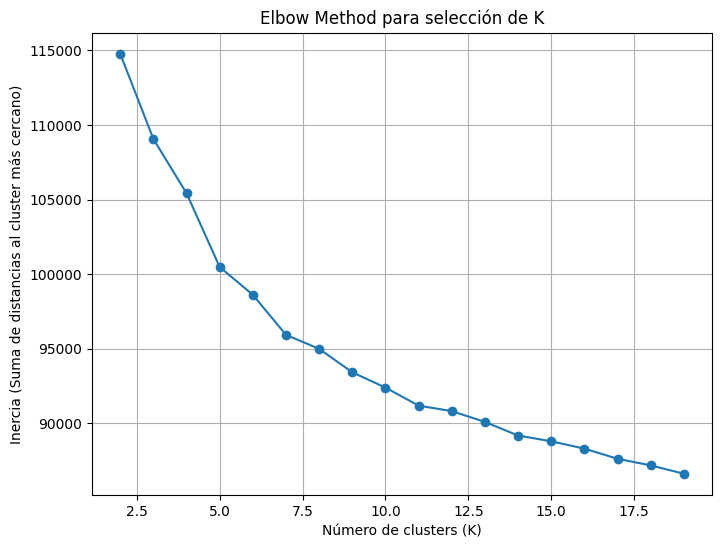

In [38]:
# @title Aplicación de **ELBOW METHOD**
inertias = []
K_values = range(2, 20)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K_values, inertias, marker='o')
plt.title("Elbow Method para selección de K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias al cluster más cercano)")
plt.grid(True)
plt.show()

En el gráfico se visualiza el codo entre 6 y 7 por ende la elección de cluster puede ser k = 6 o k = 7

In [66]:
# @title Entrenamiento de K-Means
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_df)

kmeans_labels[:10]  # ver los primeros clusters asignados

array([1, 1, 2, 3, 0, 2, 3, 3, 1, 3], dtype=int32)

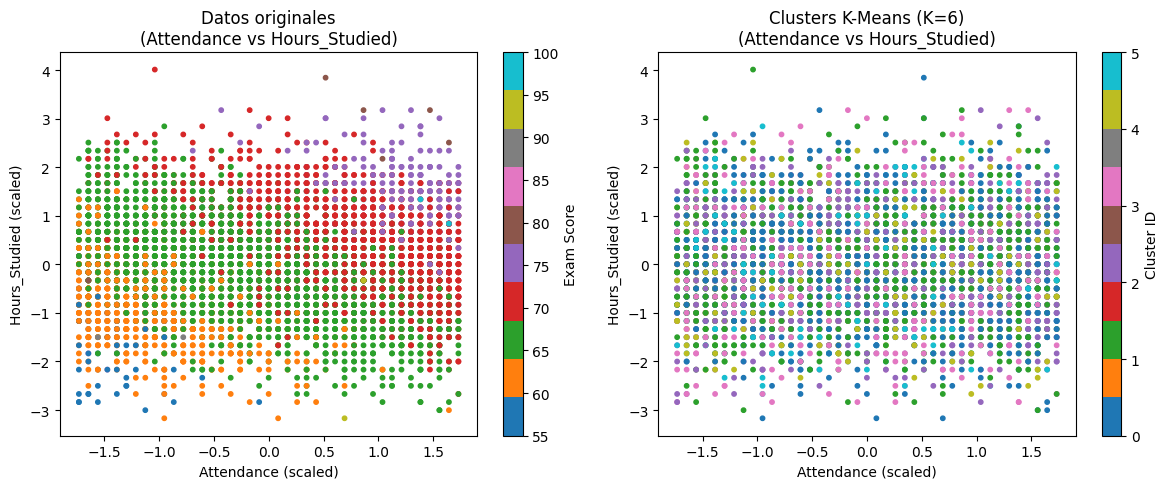

In [67]:
# @title Gráficación 2D de los datos a partir de las variables de mejor correlación

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# SUBPLOT 1: Datos originales
scatter1 = ax[0].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=y,
    cmap='tab10',
    s=10
)

ax[0].set_title("Datos originales\n(Attendance vs Hours_Studied)")
ax[0].set_xlabel("Attendance (scaled)")
ax[0].set_ylabel("Hours_Studied (scaled)")
cbar1 = fig.colorbar(scatter1, ax=ax[0])
cbar1.set_label("Exam Score")

# SUBPLOT 2: KMeans clusters
scatter2 = ax[1].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=kmeans_labels,
    cmap='tab10',
    s=10
)

ax[1].set_title("Clusters K-Means (K=6)\n(Attendance vs Hours_Studied)")
ax[1].set_xlabel("Attendance (scaled)")
ax[1].set_ylabel("Hours_Studied (scaled)")
cbar2 = fig.colorbar(scatter2, ax=ax[1])
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

Se utilizará como métrica de evaluación Silhouette Score ya que nos ayuda diciendo ¿Qué tan compactos son los clusters? y ¿Qué tan separados están entre sí?

In [63]:
# @title Score para K-Means
silhouette_kmeans = silhouette_score(X_scaled_df, kmeans_labels)
print("Score: ",silhouette_kmeans)

Score:  0.05731883775192859


<h3> <b> Análisis </b> </h3>

El algoritmo K-Means fue ajustado usando K = 6, seleccionado mediante el método del codo, donde se observó un cambio de pendiente significativo en la inercia alrededor de 6 y 7 clusters. Sin embargo, al proyectar los datos en dos variables altamente correlacionadas con el desempeño académico (Attendance y Hours_Studied), se observa que los estudiantes se distribuyen de forma continua, sin separaciones naturales claras. Esto ya dice mucho sobre que K-Means no encontrará grupos muy definidos.

El Silhouette Score obtenido (0.057) confirma esto, que los valores cercanos a cero indican que los clusters se superponen ampliamente, que la separación entre grupos es débil y que la estructura del dataset no presenta conglomerados bien formados. Entonces mientras que los datos originales muestran una relación más bien gradual entre asistencia, horas de estudio y puntaje, K-Means segmenta este espacio de forma relativamente arbitraria, dividiendo regiones donde no existen límites naturales.

# **Clasificacion por puntaje mayor igual a *70*** - Supervisado

---

In [ ]:
# @title Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 70

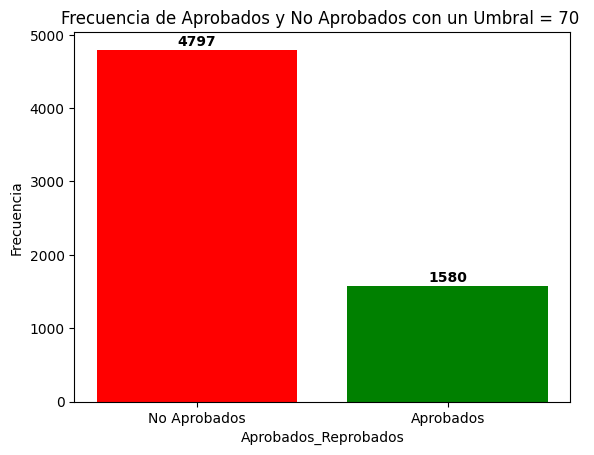

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 70 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

## **Deep learning - Modelo Superisado**

In [ ]:
# @title Proceso de entrenamiento

# Semilla fija
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preparación del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
])

model.summary()

# Correr modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=60,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)]
)

# Evaluación final
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular métricas
balanced_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Especificidad = TN / (TN + FP)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 48,385 (189.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7192 - loss: 0.5368 - val_accuracy: 0.9295 - val_loss: 0.2239
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1844 - val_accuracy: 0.9500 - val_loss: 0.1339
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.1167 - val_accuracy: 0.9481 - val_loss: 0.1206
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9801 - loss: 0.0931 - val_accuracy: 0.9520 - val_loss: 0.1149
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9857 - loss: 0.0782 - val_accuracy: 0.9559 - val_loss: 0.1112
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0667 - val_accuracy: 0.9598 - val_loss: 0.1098
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.0571 - val_accuracy: 0.9628 - val_loss: 0.1112
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 0.0490 - val_accuracy: 0.9628 - val_loss:

In [ ]:
# Reporte de metricas
print("Resultados del modelo de Clasificación (Deep Learning):\n")
print(f"Balanced Accuracy : {balanced_acc:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"Especificidad: {specificity:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

Resultados del modelo de Clasificación (Deep Learning):

Balanced Accuracy : 0.9416
Recall (Sensibilidad): 0.8987
Especificidad: 0.9844
Precisión: 0.9498
F1-Score: 0.9236


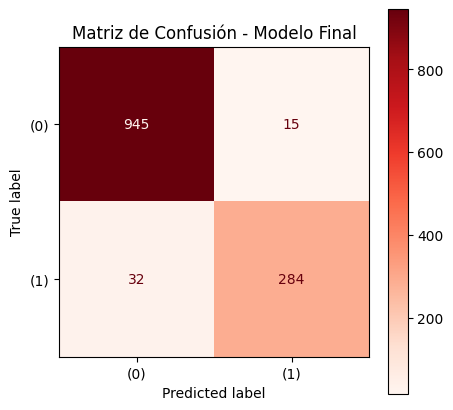

In [ ]:
# @title Matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Deep learning - Reducción dimensional**

# **Regresión** - Supervisado

---

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento

# Copia del DataFrame
df_r = df_encoded.copy()

# Variables predictoras (todas menos Exam_Score)
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo
y = df_r['Exam_Score']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train - 20% test
    random_state=42
)

## **Support Vector Machine - Modelo supervisado**

In [ ]:
# Modelo base
svr = SVR()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, y_pred = flujo_regresion(svr, param_grid, score, X_train, X_test, y_train, y_test)

ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

Mejores hiperparámetros: {'gamma': 0.001, 'kernel': 'rbf'}
Mejor evaluación promedio: 0.6500471053963317


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Evaluación final:
MAE: 0.5832
MSE: 4.32


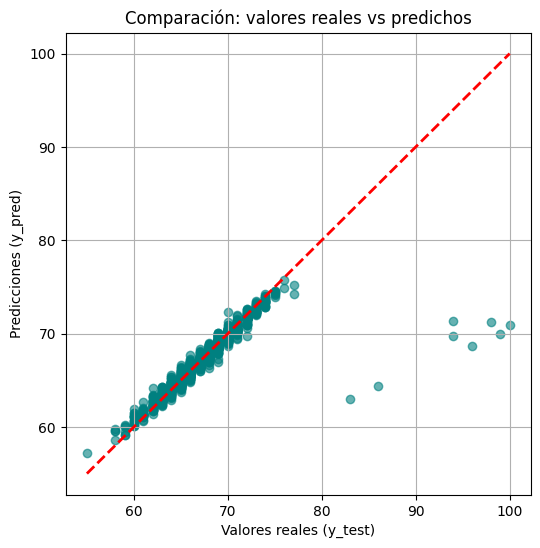

In [ ]:
# @title Gráfico de valores reales vs predicciones

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # línea ideal (predicción perfecta)

plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación: valores reales vs predichos")
plt.grid(True)
plt.show()

## **Support Vector Machine - Reducción dimensional**

## **1. K-means algorithm**

In [ ]:
# Preparación del dataset

# Copia final del dataset
df_kmeans = df_60.drop(columns=['Exam_Score'])

# Escalado de datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kmeans)

df_scaled.shape

(6377, 21)

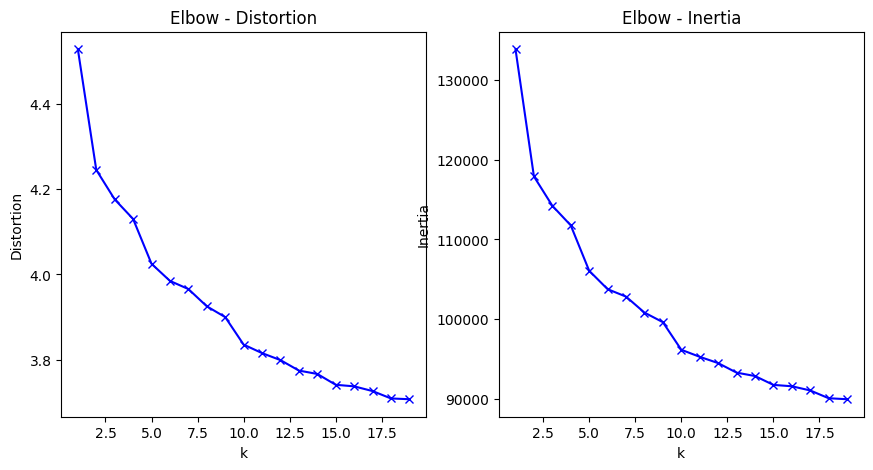

In [ ]:
distortions = []
wss = []
K = range(1, 20)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    distortions.append(
        np.mean(np.min(cdist(df_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1))
    )
    wss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
# El promedio de distancia mínima entre cada punto y el centro del cluster
plt.ylabel('Distortion')
plt.title('Elbow - Distortion')

plt.subplot(132)
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
# La suma de distancias cuadradas entre los puntos y su centroide.
plt.ylabel('Inertia')
plt.title('Elbow - Inertia')

plt.show()

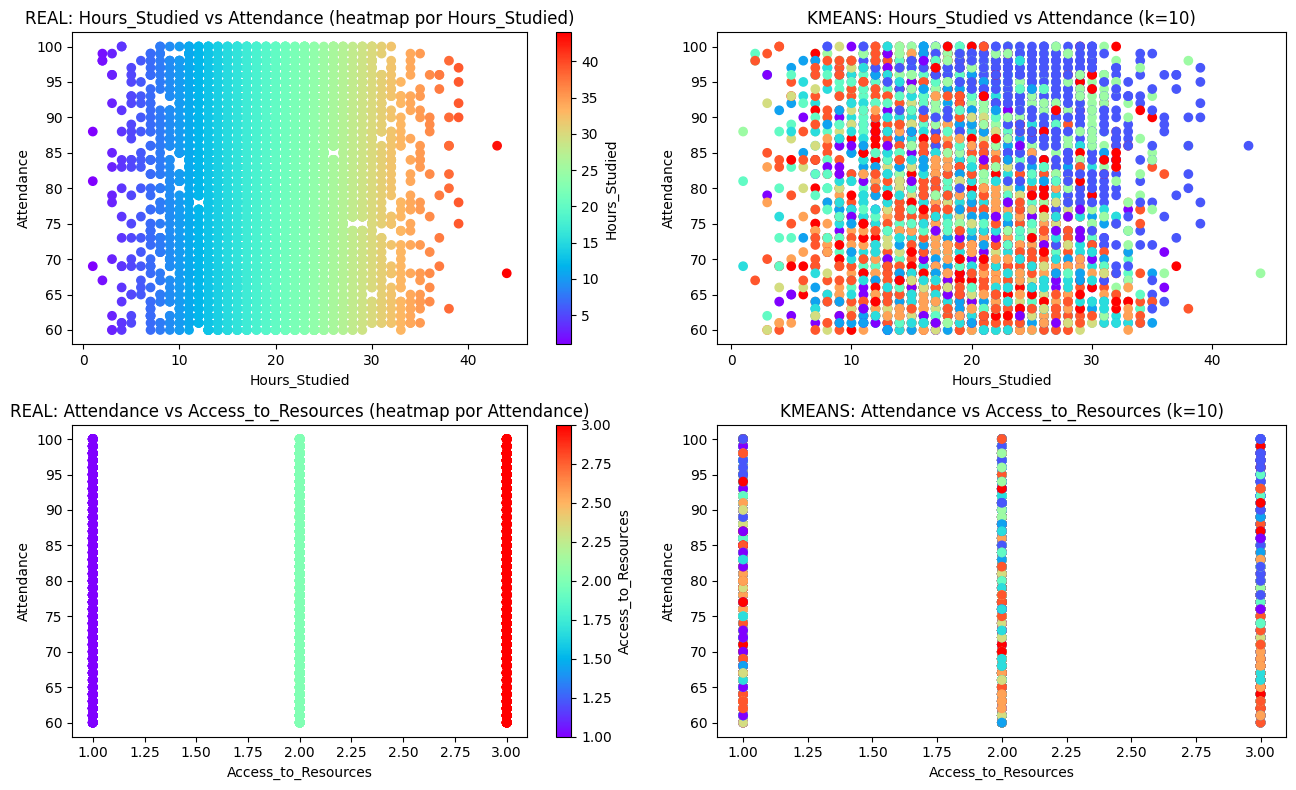

In [ ]:
# @title Entrenamiento K-means con el K = 10
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)
df_60["Cluster"] = kmeans.labels_

x1 = "Hours_Studied"
y1 = "Attendance"

y2 = "Attendance"
x2 = "Access_to_Resources"

plt.figure(figsize=(13,8))

# Hours_Studied vs Attendance (valores reales)
plt.subplot(221)
plt.scatter(df_60[x1], df_60[y1], c=df_60[x1], cmap="rainbow")
plt.colorbar(label=x1)
plt.xlabel(x1)
plt.ylabel(y1)
plt.title("REAL: Hours_Studied vs Attendance (heatmap por Hours_Studied)")

#  Hours_Studied vs Attendance (KMeans)
plt.subplot(222)
plt.scatter(df_60[x1], df_60[y1], c=df_60["Cluster"], cmap="rainbow")
plt.xlabel(x1)
plt.ylabel(y1)
plt.title(f"KMEANS: Hours_Studied vs Attendance (k={k})")

# Attendance vs Access_to_Resources (valores reales)
plt.subplot(223)
plt.scatter(df_60[x2], df_60[y2], c=df_60[x2], cmap="rainbow")
plt.colorbar(label=x2)
plt.xlabel(x2)
plt.ylabel(y2)
plt.title("REAL: Attendance vs Access_to_Resources (heatmap por Attendance)")

# Attendance vs Access_to_Resources (KMeans)

plt.subplot(224)
plt.scatter(df_60[x2], df_60[y2], c=df_60["Cluster"], cmap="rainbow")
plt.xlabel(x2)
plt.ylabel(y2)
plt.title(f"KMEANS: Attendance vs Access_to_Resources (k={k})")

plt.tight_layout()
plt.show()

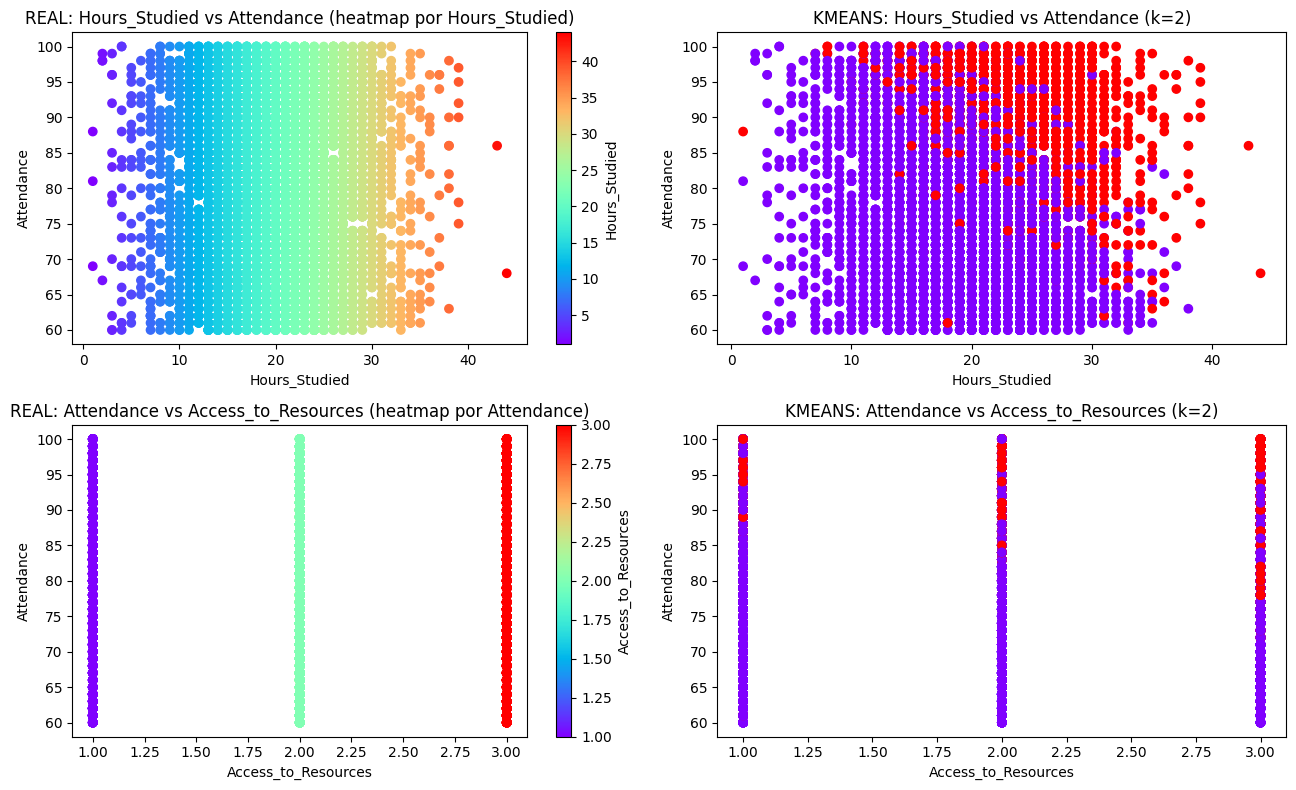

In [ ]:
#  @title Entrenamiento K-means con el K = 2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)
df_60["Cluster"] = kmeans.labels_

x1 = "Hours_Studied"
y1 = "Attendance"

y2 = "Attendance"
x2 = "Access_to_Resources"

plt.figure(figsize=(13,8))

# Hours_Studied vs Attendance (valores reales)
plt.subplot(221)
plt.scatter(df_60[x1], df_60[y1], c=df_60[x1], cmap="rainbow")
plt.colorbar(label=x1)
plt.xlabel(x1)
plt.ylabel(y1)
plt.title("REAL: Hours_Studied vs Attendance (heatmap por Hours_Studied)")

#  Hours_Studied vs Attendance (KMeans)
plt.subplot(222)
plt.scatter(df_60[x1], df_60[y1], c=df_60["Cluster"], cmap="rainbow")
plt.xlabel(x1)
plt.ylabel(y1)
plt.title(f"KMEANS: Hours_Studied vs Attendance (k={k})")

# Attendance vs Access_to_Resources (valores reales)
plt.subplot(223)
plt.scatter(df_60[x2], df_60[y2], c=df_60[x2], cmap="rainbow")
plt.colorbar(label=x2)
plt.xlabel(x2)
plt.ylabel(y2)
plt.title("REAL: Attendance vs Access_to_Resources (heatmap por Attendance)")

# Attendance vs Access_to_Resources (KMeans)

plt.subplot(224)
plt.scatter(df_60[x2], df_60[y2], c=df_60["Cluster"], cmap="rainbow")
plt.xlabel(x2)
plt.ylabel(y2)
plt.title(f"KMEANS: Attendance vs Access_to_Resources (k={k})")

plt.tight_layout()
plt.show()

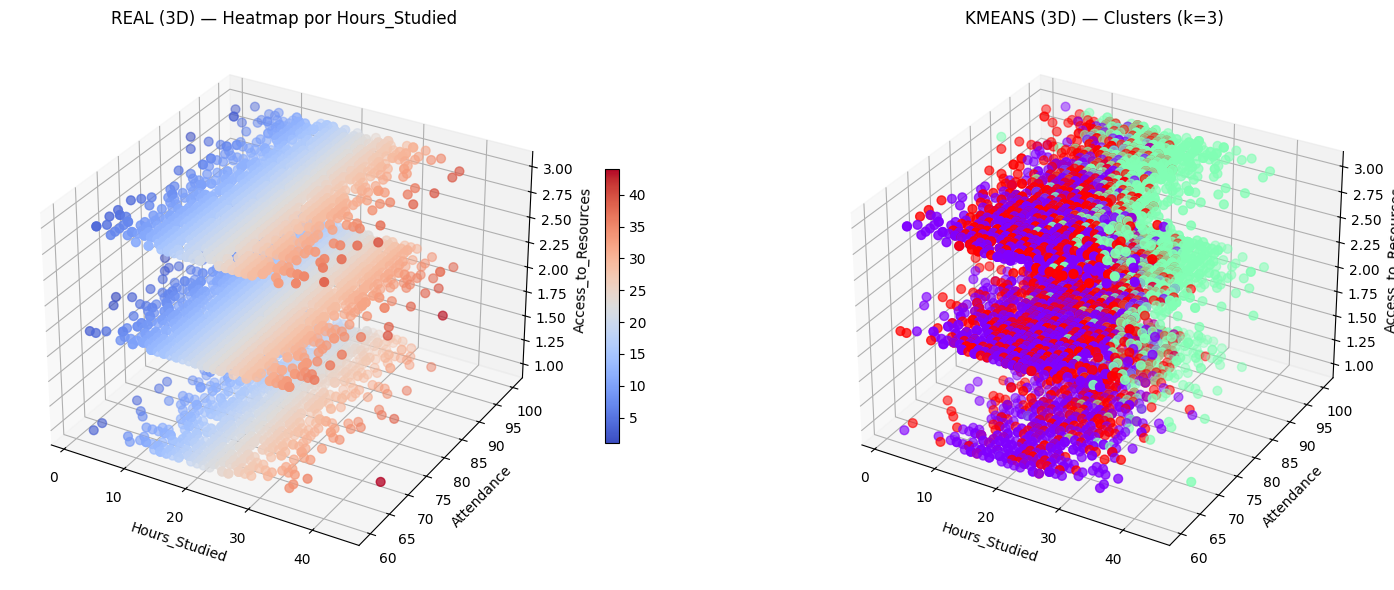

In [ ]:
# @title Entrenamiento con K = 3

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)
df_60["Cluster"] = kmeans.labels_


# Variables 3D

X = "Hours_Studied"
Y = "Attendance"
Z = "Access_to_Resources"

# FIGURA — REAL (heatmap por Hours_Studied)

fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(121, projection='3d')
p = ax.scatter(
    df_60[X],
    df_60[Y],
    df_60[Z],
    c=df_60[X],
    cmap="coolwarm",
    s=40
)

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_zlabel(Z)
ax.set_title("REAL (3D) — Heatmap por Hours_Studied")
fig.colorbar(p, ax=ax, shrink=0.5)

# FIGURA — KMEANS (k = 3)

ax2 = fig.add_subplot(122, projection='3d')
p2 = ax2.scatter(
    df_60[X],
    df_60[Y],
    df_60[Z],
    c=df_60["Cluster"],
    cmap="rainbow",
    s=40
)

ax2.set_xlabel(X)
ax2.set_ylabel(Y)
ax2.set_zlabel(Z)
ax2.set_title(f"KMEANS (3D) — Clusters (k={k})")

plt.tight_layout()
plt.show()


## **2. DBSCAN  $O(n^2)$**

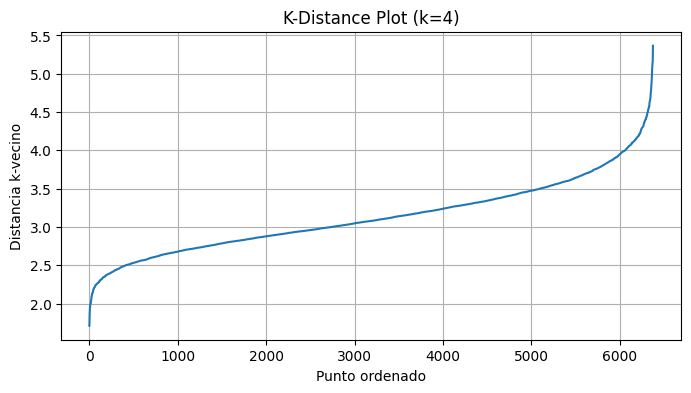

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Calcular distancias a los vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Ordenar distancias
distances = np.sort(distances[:, 3])
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("K-Distance Plot (k=4)")
plt.xlabel("Punto ordenado")
plt.ylabel("Distancia k-vecino")
plt.grid(True)
plt.show()

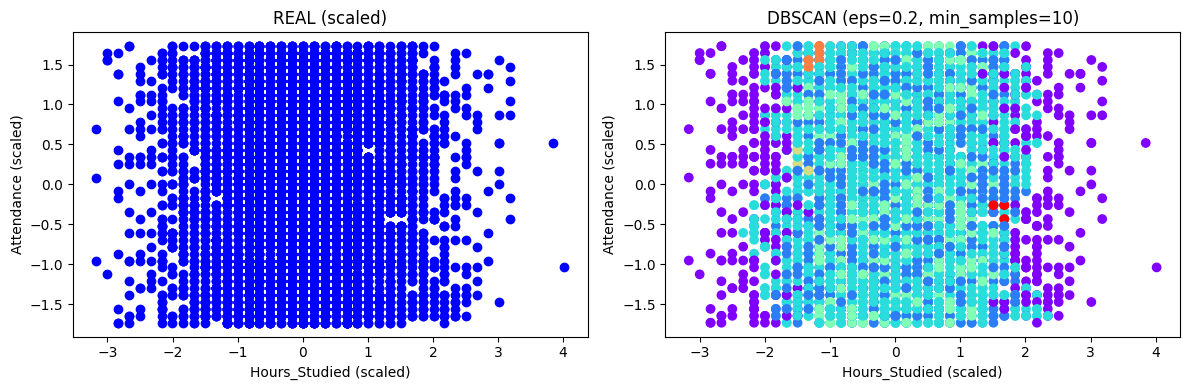

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


# ESCALAR TUS TRES VARIABLES

features = ["Hours_Studied", "Attendance", "Access_to_Resources"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_60[features])


# ENTRENAR DBSCAN (similar al ejemplo)

eps = 0.2
min_samples = 10

dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_scaled)

df_60["Cluster_DBSCAN"] = dbs.labels_


# FIGURA PRINCIPAL CON FORMATO DEL EJEMPLO

plt.figure(figsize=(12,4))


# Datos reales

plt.subplot(121)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c="blue")
plt.title("REAL (scaled)")
plt.xlabel("Hours_Studied (scaled)")
plt.ylabel("Attendance (scaled)")


# Clusters DBSCAN

plt.subplot(122)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=df_60["Cluster_DBSCAN"], cmap="rainbow")
plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})")
plt.xlabel("Hours_Studied (scaled)")
plt.ylabel("Attendance (scaled)")

plt.tight_layout()
plt.show()


## **3. Aglomerative clustering**

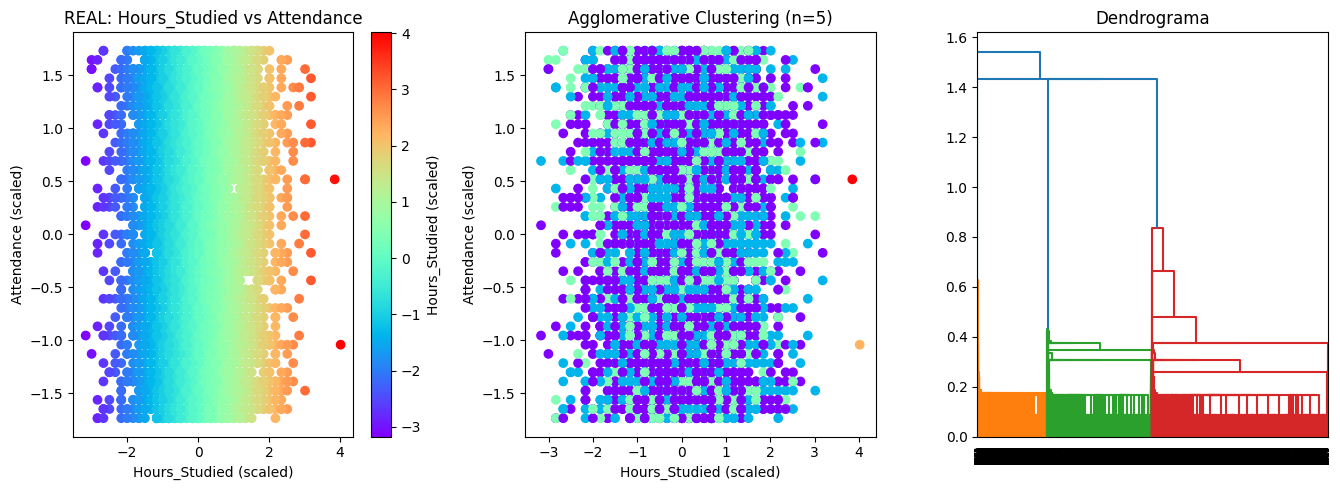

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Selección de variables
features = ["Hours_Studied", "Attendance", "Access_to_Resources"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_60[features])

# Agglomerative Clustering
n_clusters = 5
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
agg.fit(X_scaled)

df_60["Cluster_AGG"] = agg.labels_

# Para el dendrograma
clusters = hierarchy.linkage(X_scaled, method="single")

# FIGURA PRINCIPAL
plt.figure(figsize=(18,5))


# Datos reales

plt.subplot(141)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=X_scaled[:,0], cmap="rainbow")
plt.title("REAL: Hours_Studied vs Attendance")
plt.xlabel("Hours_Studied (scaled)")
plt.ylabel("Attendance (scaled)")
plt.colorbar(label="Hours_Studied (scaled)")


# Agglomerative Clustering

plt.subplot(142)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=df_60["Cluster_AGG"], cmap="rainbow")
plt.title(f"Agglomerative Clustering (n={n_clusters})")
plt.xlabel("Hours_Studied (scaled)")
plt.ylabel("Attendance (scaled)")


# Dendrograma

plt.subplot(143)
hierarchy.dendrogram(clusters)
plt.axhline(150, color='red', linestyle='--')
plt.axhline(100, color='crimson')
plt.title("Dendrograma")

plt.tight_layout()
plt.show()

